In [29]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import os

In [2]:
folder_path = '../data/Traffic_data'

dataframes = {}

for file in os.listdir(folder_path):
    if file.endswith('.traffic.htm'):
        file_path = os.path.join(folder_path, file)
        file_name = file.split('.')[0]
        df_list = pd.read_html(file_path)
        df = df_list[4]
        df = df.iloc[1:].reset_index(drop=True)
        df_key = file_name
        dataframes[df_key] = df

In [2]:
traffic_df = pd.read_csv('../data/traffic_df.csv', sep=',')

In [92]:
df = pd.read_csv('../data/traffic_df_with_bridges.csv')
df.head(5)

,Road,Name,LRP,Offset,Chainage,LRP_2,Offset_2,Chainage_2,(Km),Heavy Truck,...,Cart,Motorized,Non Motorized,Total AADT,(AADT),base_road,condition,lat,lon,Type
0,N1-1L,Jatrabari - Int.with Z1101 (Left) (Left),LRPS,0.0,0.000,LRPS,822.0,0.822,0.822,402.0,...,0.0,18236.0,1121.0,19357.0,19357.0,N1,NaN,23.706028,90.443333,Intersection
1,N1-1R,Jatrabari - Int.with Z1101 (Left) (Right),LRPS,0.0,0.000,LRPS,822.0,0.822,0.822,660.0,...,0.0,20236.0,1301.0,21537.0,21537.0,N1,NaN,23.706028,90.443333,Intersection
2,N1-2L,Int.with Z1101 - Signboard (Left) R111 (Left),LRPS,822.0,0.822,LRPS,4175.0,4.175,3.353,660.0,...,0.0,20236.0,1301.0,21537.0,21537.0,N1,NaN,23.702778,90.450472,Intersection
3,N1-2R,Int.with Z1101 - Signboard (Left) R111 (Right),LRPS,822.0,0.822,LRPS,4175.0,4.175,3.353,402.0,...,0.0,18236.0,1121.0,19357.0,19357.0,N1,NaN,23.702778,90.450472,Intersection
4,NaN,.,NaN,NaN,1.800,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,N1,A,23.698739,90.458861,Bridge


In [132]:
index_bridges = df[df['Road'].isnull()].index
index_roads = df[df['Road'].notnull()].index
df['Type'] = pd.NA
df.loc[index_roads, 'Type'] = 'Road'
df.loc[index_bridges, 'Type'] = 'Bridge'

df['Connected_Road1'] = None
df['Connected_Road2'] = None
df['Connected_Road3'] = None

all_road_names = df['Name'].str.findall(r'([nNzZrR]\s*\d+)')

for index, matches in all_road_names.items():
    # Ensure matches is a list; treat NaN (float) as an empty list
    matches = matches if isinstance(matches, list) else []
    
    if len(matches) >= 1:
        df.at[index, 'Connected_Road1'] = matches[0]
    if len(matches) >= 2:
        df.at[index, 'Connected_Road2'] = matches[1]
    if len(matches) >= 3:
        df.at[index, 'Connected_Road3'] = matches[2]

df.loc[df['Connected_Road1'].notna(), 'Type'] = 'Intersection'
df.to_csv('../data/traffic_df_with_bridges_and_intersections.csv', index=False)

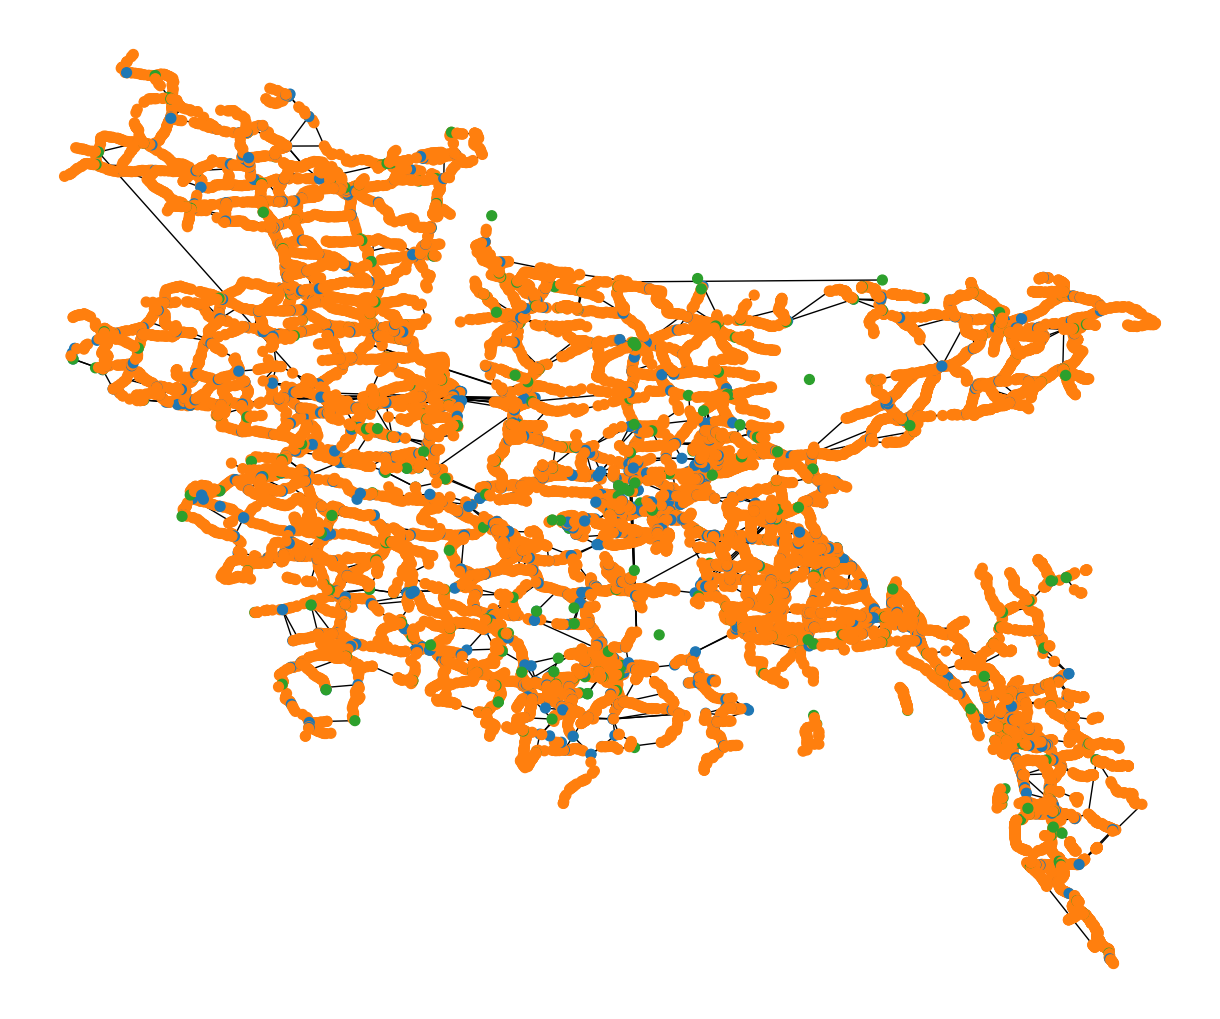

In [31]:
df = pd.read_csv('../data/traffic_df_with_bridges_and_intersections.csv', low_memory=False)

G = nx.Graph()

for index, row in df.iterrows():
    node_attributes = row.to_dict()
    G.add_node(index, **node_attributes)

df_sorted = df.sort_values(by=['base_road', 'Chainage'])

previous_node = None
previous_base_road = None

for index, row in df_sorted.iterrows():
    current_base_road = row['base_road']
  
    if previous_node is not None and previous_base_road == current_base_road:
        G.add_edge(previous_node, index)
    
    previous_node = index
    previous_base_road = current_base_road

# Re-filter intersections with valid 'lon' and 'lat' and redefine the distance calculation function
intersections = [node for node, attr in G.nodes(data=True) if attr['Type'] == 'Intersection' and not pd.isna(attr['lon']) and not pd.isna(attr['lat'])]

def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth using their latitude and longitude.
    """
    # Convert latitude and longitude from degrees to radians
    phi1, lambda1, phi2, lambda2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    delta_lambda = lambda2 - lambda1
    delta_phi = phi2 - phi1
    a = np.sin(delta_phi/2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    # Earth radius in kilometers (approx)
    R = 6371.0

    # Distance in kilometers
    distance = R * c
    return distance

# Re-attempt to connect intersections to the closest node with matching base_road using the correct distance calculation
for intersection in intersections:
    connected_roads = [G.nodes[intersection].get(f'Connected_Road{i}') for i in range(1, 4)]
    connected_roads = [road for road in connected_roads if road and not pd.isna(road)]
    
    # For each connected road, find the closest node and connect
    for connected_road in connected_roads:
        potential_nodes_for_road = [node for node, attr in G.nodes(data=True) if attr['base_road'] == connected_road and not pd.isna(attr['lon']) and not pd.isna(attr['lat'])]
        
        min_distance = np.inf
        closest_node = None
        intersection_lat = G.nodes[intersection]['lat']
        intersection_lon = G.nodes[intersection]['lon']
        
        for node in potential_nodes_for_road:
            node_lat = G.nodes[node]['lat']
            node_lon = G.nodes[node]['lon']
            distance = calculate_distance(intersection_lat, intersection_lon, node_lat, node_lon)
            
            if distance < min_distance:
                min_distance = distance
                closest_node = node
        
        if closest_node is not None:
            G.add_edge(intersection, closest_node)

unique_types = df['Type'].unique()
colors = plt.cm.tab10(range(len(unique_types)))
color_map = dict(zip(unique_types, colors))

plt.figure(figsize=(12,10))
node_colors = [color_map[G.nodes[node]['Type']] for node in G.nodes]
pos = {node:(G.nodes[node]['lon'], G.nodes[node]['lat']) for node in G.nodes}
nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=50)
plt.show()

In [34]:
G.shortest_path(1,23)

AttributeError: 'Graph' object has no attribute 'shortest_path'

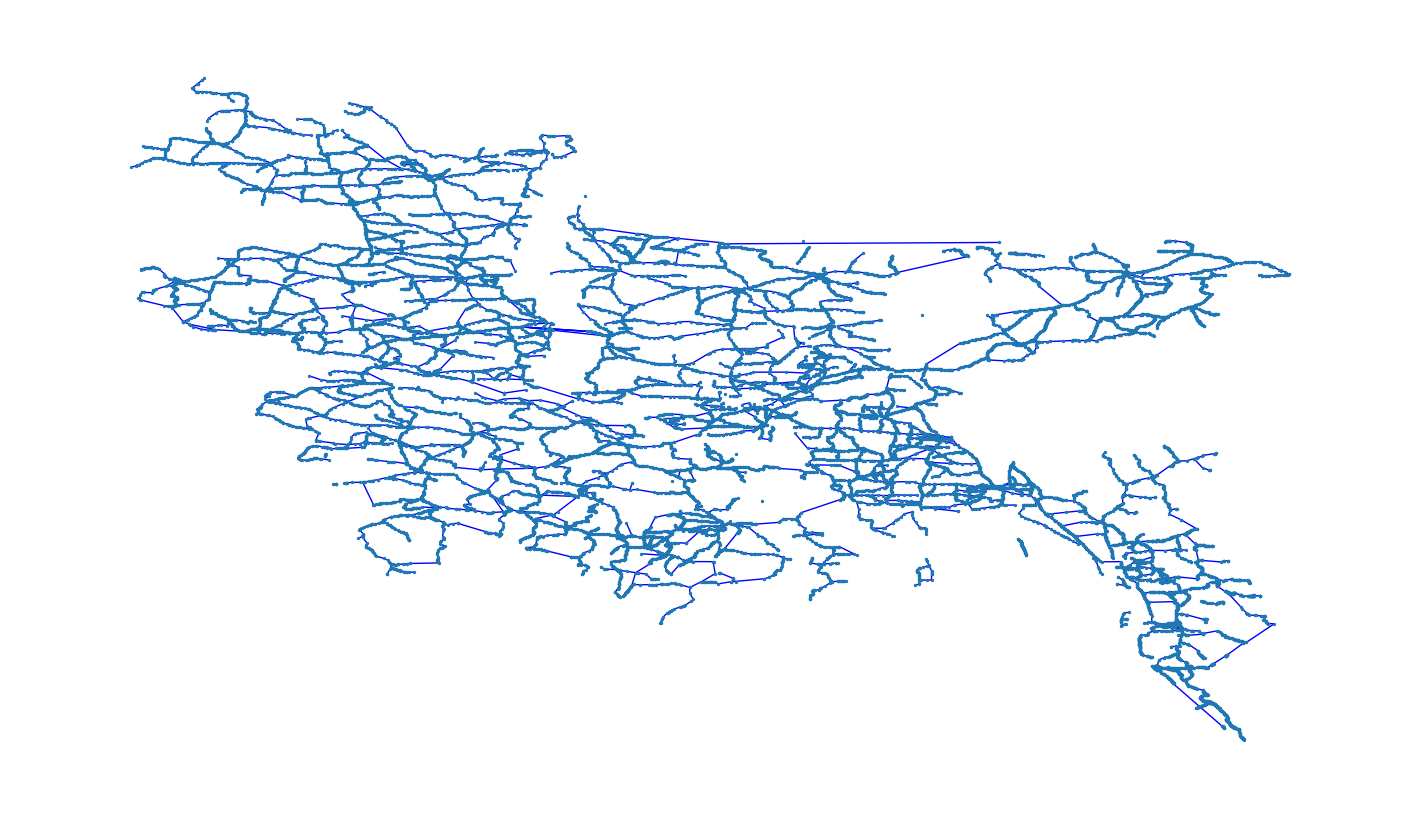

In [34]:
positions = {index: (row['lon'], row['lat']) for index, row in df.iterrows()}
# Ensure the data is sorted by 'base_road' and 'Chainage'
df_sorted = df.sort_values(by=['base_road', 'Chainage'])

# Creating a new DataFrame to hold nodes with positions and chainage for connection logic
df_nodes = df_sorted[['lat', 'lon', 'Chainage', 'base_road']].dropna()

# Reset index to ensure the nodes are indexed sequentially for graph construction
df_nodes.reset_index(drop=True, inplace=True)

# Create positions dictionary again based on the sorted and cleaned DataFrame
positions = {index: (row['lon'], row['lat']) for index, row in df_nodes.iterrows()}

# Create the graph again
G = nx.Graph()

# Add nodes with positions and additional attributes (for potential future use)
for node, row in df_nodes.iterrows():
    G.add_node(node, pos=(row['lon'], row['lat']), chainage=row['Chainage'], base_road=row['base_road'])

# Add edges based on sequential chainage within the same base_road
for i in range(len(df_nodes) - 1):
    if df_nodes.iloc[i]['base_road'] == df_nodes.iloc[i+1]['base_road']:
        G.add_edge(i, i+1)

# Extract positions from graph nodes for plotting
# Draw the graph, including edges
# Add nodes with positions
for node, pos in positions.items():
    G.add_node(node, pos=pos)

# Extract positions from graph nodes for plotting
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(14, 8))
# Draw the graph
nx.draw(G, pos, node_size=2, with_labels=False, edge_color='b')  # Adjust node_size for better visibility, with_labels for node ids
plt.show()